In [94]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [78]:
WINE_DATASET_LOCATION = './winemag-data-130k-v2.csv'
df = pd.read_csv(WINE_DATASET_LOCATION, index_col=0)

# Brief Analysis

In [79]:
df.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Taking a quick glance at the dataset, we can quickly get our possible target for our machine learning project.

Let's try to predict the score of a wine by it's features!

Since SKLearn can't work with strings in categorical features, we will need at least a bit of preprocessing, to avoid creating too many columns we will be utilizing the ordinal encoder from scikit-learn itself.

Since the taster itself may induce some bias towards some wines, we will be including it as a feature for testing.

In [80]:
#simple data cleaning
df = df.dropna(subset=['price']).fillna("-1")

Our pipeline will be very similar from the Decision Tree to the Random Forest. We will be using regressors for both, since it can be described as a regression problem. Another possible approach (which I have already taken on another time and do not wish to re-do because I have already done it) is to group the scores by a certain range and do a classification problem instead of a regression.

Our pipeline will be the following:

In [171]:
ord_encoder_columns = [
  'country',
  'designation',
  'region_1',
  'region_2',
  'taster_name',
  'variety',
  'winery'
]

transforming_pipeline = ColumnTransformer([
  ('ordinal_encoder', OrdinalEncoder(
      handle_unknown='use_encoded_value',
      unknown_value=-1
  ), ord_encoder_columns),
])

rf_pipeline = Pipeline([
  ('encoding', transforming_pipeline),
  ('model', RandomForestRegressor())
])

dt_pipeline = Pipeline([
  ('encoding', transforming_pipeline),
  ('model', DecisionTreeRegressor())
])

First we pass all our categorical columns to an Ordinal Encoder, such that categorical values (strings in the table, such as countries) become numbers which are accepted by both models.

If we do not know the encoding for a category (such as, a category only seen in the test group and not seen in the training subset) we will attribute it the value -1 so that it will not raise an error and will still be able to be scored.

In [172]:
train, test = train_test_split(df, test_size=0.1, shuffle=True)

We then create a train and test split of 10% of the data to the train. Since the hyperoptimization runs a cross validation algorithm we do not need to create a validation set ourselves.

In [173]:
print(f"Train set shape: {train.shape}")
#print(f"Validation set shape: {val.shape}")
print(f"Test set shape: {test.shape}")

Train set shape: (108877, 13)
Test set shape: (12098, 13)


In [175]:
FEATURES = [
  'country',
  'designation',
  'region_1',
  'region_2',
  'taster_name',
  'variety',
  'winery',
  'price'
]
TARGET = 'points'

X_train, X_test = train[FEATURES], test[FEATURES] 
y_train, y_test = train[TARGET], test[TARGET]

This split leaves us with about 110k occurences in the train dataset and 12k wines in the test set

We then instantiate a random grid to search best params on the random forest and the decision tree, we will be using the RandomizedSearch algorithm from the scikit-learn library to find the best params for both of our models.

In [215]:
int_vec = np.vectorize(int)
rf_random_grid = {
  'model__n_estimators': int_vec(np.linspace(50, 100, 100)),
  'model__max_features': ["auto", "sqrt", "log2"],
  'model__max_depth': int_vec(np.linspace(3, 15, 10)),
  'model__min_samples_split': int_vec(np.linspace(2, 30, 10)),
  'model__min_samples_leaf': int_vec(np.linspace(1, 10, 10)),
  'model__bootstrap': [True, False]
}

dt_random_grid = {
  'model__max_features': ["auto", "sqrt", "log2"],
  'model__max_depth': int_vec(np.linspace(3, 30, 20)),
  'model__min_samples_split': int_vec(np.linspace(2, 30, 10)),
  'model__min_samples_leaf': int_vec(np.linspace(1, 10, 10))
}

Since the RandomizedSearch utilizes an increasing metric as it's best score (and I did not read enough of it's documentation on how to flip it) we will be using the inverted mse score to fine-tune our algorithm, the formula below is contained in the function.

This metric increases to a max of 1 as the MSE decreases and get closer to 0 as the MSE increases

In [216]:
def mse_score_hyperopt(scorer, X, y):
  return 1/(mean_squared_error(y, scorer.predict(X))+1)

gridsearch_rf = RandomizedSearchCV(
    rf_pipeline,
    rf_random_grid,
    n_iter=15,
    scoring=mse_score_hyperopt,
    n_jobs=1
)

gridsearch_dt = RandomizedSearchCV(
    dt_pipeline,
    dt_random_grid,
    n_iter=15,
    scoring=mse_score_hyperopt,
    n_jobs=1
)

gridsearch_rf.fit(X_train, y_train)
gridsearch_dt.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('encoding',
                                              ColumnTransformer(transformers=[('ordinal_encoder',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['country',
                                                                                'designation',
                                                                                'region_1',
                                                                                'region_2',
                                                                                'taster_name',
                                                                                'variety',
                                             

Since we are creating some very dense forests (n_estimators) with big trees (max_depth) we will run the algorithm for few rounds, it was also noticeable during the creation of this code that the score changes very little.

In [217]:
gridsearch_rf.best_params_

{'model__bootstrap': True,
 'model__max_depth': 15,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 3,
 'model__min_samples_split': 5,
 'model__n_estimators': 74}

In [218]:
gridsearch_dt.best_params_

{'model__max_depth': 14,
 'model__max_features': 'auto',
 'model__min_samples_leaf': 6,
 'model__min_samples_split': 14}

In [219]:
rf_pipeline.set_params(**gridsearch_rf.best_params_)
dt_pipeline.set_params(**gridsearch_dt.best_params_)

Pipeline(steps=[('encoding',
                 ColumnTransformer(transformers=[('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['country', 'designation',
                                                   'region_1', 'region_2',
                                                   'taster_name', 'variety',
                                                   'winery'])])),
                ('model',
                 DecisionTreeRegressor(max_depth=14, max_features='auto',
                                       min_samples_leaf=6,
                                       min_samples_split=14))])

In [220]:
rf_pipeline.fit(X_train, y_train)
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('encoding',
                 ColumnTransformer(transformers=[('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['country', 'designation',
                                                   'region_1', 'region_2',
                                                   'taster_name', 'variety',
                                                   'winery'])])),
                ('model',
                 DecisionTreeRegressor(max_depth=14, max_features='auto',
                                       min_samples_leaf=6,
                                       min_samples_split=14))])

In [221]:
rf_pipeline.predict(X_test)
dt_pipeline.predict(X_test)

array([91.79166667, 88.08783784, 87.06896552, ..., 86.21428571,
       86.64      , 89.26315789])

In [230]:
X_test['predicted_points_rf'] = rf_pipeline.predict(X_test)
X_test['predicted_points_dt'] = dt_pipeline.predict(X_test)
X_test['points'] = y_test


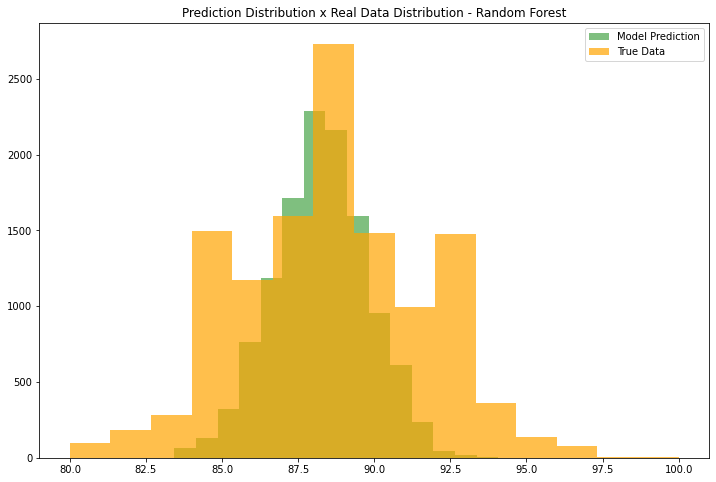

In [231]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.title("Prediction Distribution x Real Data Distribution - Random Forest")
plt.hist(X_test['predicted_points_rf'], color='green', alpha=0.5, label='Model Prediction', bins=15)
plt.hist(X_test['points'], color='orange', alpha=0.7, label='True Data', bins=15)
plt.legend()
plt.show()

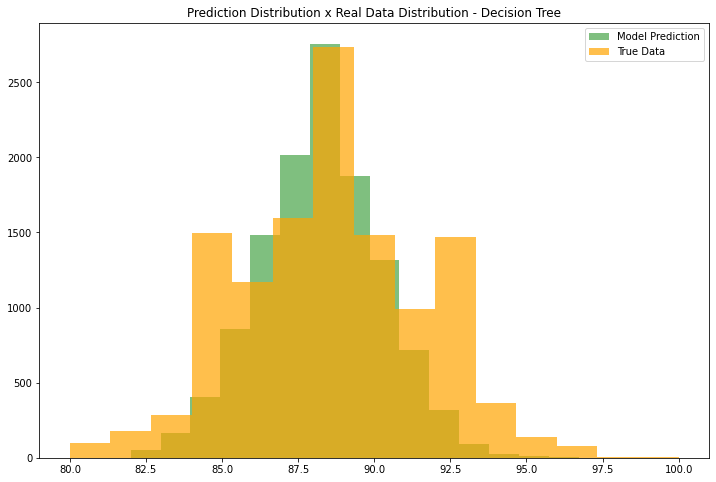

In [232]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plt.title("Prediction Distribution x Real Data Distribution - Decision Tree")
plt.hist(X_test['predicted_points_dt'], color='green', alpha=0.5, label='Model Prediction', bins=15)
plt.hist(X_test['points'], color='orange', alpha=0.7, label='True Data', bins=15)
plt.legend()
plt.show()

In [245]:
X_test.loc[:, 'error_rf'] = X_test['predicted_points_rf']-X_test['points']
X_test.loc[:, 'absolute_error_rf'] = np.abs(X_test['error_rf'])

X_test.loc[:, 'error_dt'] = X_test['predicted_points_dt']-X_test['points']
X_test.loc[:, 'absolute_error_dt'] = np.abs(X_test['error_dt'])

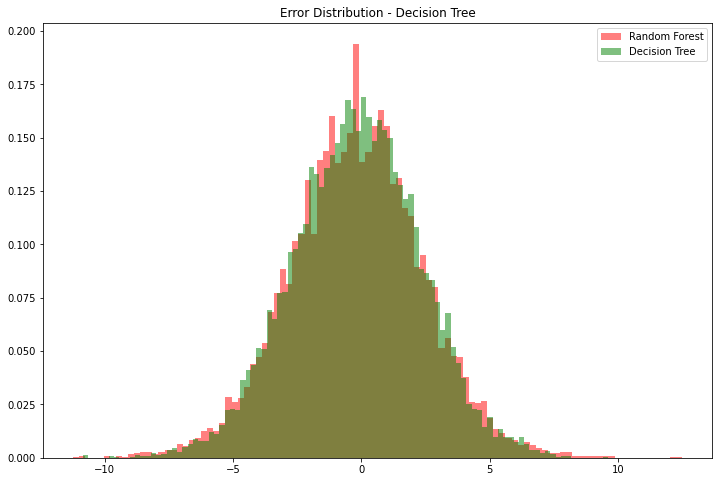

In [256]:
plt.figure(figsize=(12,8))
plt.title("Error Distribution - Decision Tree")
plt.hist(X_test['error_dt'], color='red', alpha=0.5, label='Random Forest', bins=100, density=True)
plt.hist(X_test['error_rf'], color='green', alpha=0.5, label='Decision Tree', bins=100, density=True)
plt.legend()
plt.show()

In [248]:
X_test['absolute_error_rf'].describe()

count    12098.000000
mean         1.978997
std          1.516004
min          0.000072
25%          0.782275
50%          1.676183
75%          2.840945
max         10.855068
Name: absolute_error_rf, dtype: float64

In [249]:
X_test['absolute_error_dt'].describe()

count    12098.000000
mean         2.049980
std          1.622230
min          0.000000
25%          0.802817
50%          1.692308
75%          2.927896
max         12.500000
Name: absolute_error_dt, dtype: float64

## Random Forest
As we can see on the graph above, we have an error centered in 0 and that presents to us a Gaussian/Normal distribution. Such that it is possible to say that our random forest model was capable of reasonably understanding the wine critics behavior. It is also worth noting that the error has an maximum value of 10 (be it positive or negative)

Albeit being an error of 10% of the max value of the scale it is also worth noting that the critics have not given a score below 80, as seen in the Prediction x Real Data distribution histogram above, so our error becomes much larger in comparison to the real data that is observed, since, if we consider the true range to be of 80-100, it is kinda bad to be unaccurate by at most 10.

That said, since we have a simple categorical treatment, do not use the description field (since it would require much more work), it is an acceptable error to miss on average about 2 points on each review

## Decision Tree
The same points said before to the random forest model also apply to the decision tree model, even though it got a relatively close score, this could be due to the simplicity of the task (or the under-engineering of the task). If we had a more complex dataset (column wise) it could have not performed as well.

This is not to say the decision tree should be discarded altogether, it has an amazing efficiency even on larger datasets, since we are only building a single tree (instead of a forest), so it should be capable of dealing with larger data (row wise) with relatively ease. For example, the decision tree kept the same hyperparameter optimizing algorithm of the Random Forest, which ran in 11 minutes, running in under 2 minutes.
